<a id="0"></a> <br>
# 0. Introduction

The international language of communication and code writing is English, so this notebook will be written and described in English.

Models in this code will be evaluated using the gini metric, because uplift@30 and other uplifts are not intuitive (except uplift@100). $$ gini = 2 * roc\_auc - 1$$

The exploratory data analysis was written in a different file and to keep the code compact this code is written without EDA. If it is necessary, I will show you how I did EDA (with all box plots and histograms).

While doing EDA, I noticed the following:
1. Outliers in age column in clients.csv
2. The product_quantity field has zero values in some rows in train and test purch (its incorrect)
3. Some columns have Nan values

For this task I have chosen that I will train a linear model (tree based model), so the preprocessing is appropriate. 

The kaggle does not allow us to use multiple files and you want to see the code in one notebook, so all my code has been split into functions (according to structural programming) to be more readable.

I tried to use code with a small number of features (like a solution from ODS or notebooks by Max Babushkin), but they didn't give very good results, so I decided to make as many features as possible. (because at any time we can remove unnecessary features)

I will summarize the results at the end of the file

<a id="-1"></a> <br>
# Table of content:
[0. Introduction](#0)<br>
[1. Configuration part](#1)<br>
[2. Pre-processing part](#2)<br>
[2.1. Functions for load and prepare](#2.1)<br>
[2.2. Utils for features](#2.2)<br>
[2.3. Functions and data for prepare purchase's features](#2.3)<br>
[2.4. Functions and data for prepare product's features](#2.4)<br>
[2.5. Functions and data for prepare client's features](#2.5)<br>
[2.6. Executing preprocessing](#2.6)<br>
[2.7. Spliting features for future training](#2.7)<br>
[3. Evaluating different models and different ways of training](#3.)<br>
[4. Summary](#4.)<br>
[4.1. Failed attempts](#4.1)<br>
[4.2. In future versions of the program it is worth improving](#4.2)<br>

In [1]:
import logging
import os
import pickle
import sys
import warnings
from datetime import datetime
from datetime import timedelta
from typing import Dict
from typing import Optional
from typing import Tuple

import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from implicit.als import AlternatingLeastSquares
from lightgbm import LGBMClassifier
from scipy import sparse
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
!pip install scikit-uplift

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 186.7 kB/s eta 0:00:00


In [3]:
import sklift
from sklift.metrics import uplift_at_k
from sklift.models import ClassTransformation
from sklift.models import SoloModel
from sklift.models import TwoModels

<a id="1"></a>
# 1. Configuration part ([Table of content link](#-1))

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/uplift-shift-23/baseline.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/train_purch/train_purch.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/products.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/clients2.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/train.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/test.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/test_purch/test_purch.csv


In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Since I like to use the logger library,
# but it's not convenient to use this library in kaggle, 
# so let's use my logger
class PersonaLogger:
    @staticmethod
    def info(text:str):
        print(f'[{pd.Timestamp(datetime.now()).round("s")}]\tINFO\t{text}')

logger = PersonaLogger()

PROJECT_PATH = '/kaggle/input/uplift-shift-23/x5-uplift-valid/'
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_PURCH_PATH = os.path.join(PROJECT_PATH, 'train_purch')
TEST_PURCH_PATH = os.path.join(PROJECT_PATH, 'test_purch')

RANDOM_STATE = 1

# Values for debug
N_ALS_ITERATIONS = 15

# Date of last purchase(rounded to day) in a concatenated train and test dataset
# I fixed it rigidly to simplify the code
MAILING_DATETIME = datetime(2019, 3, 19)
logger.info('Done')

[2023-01-11 03:41:12]	INFO	Done


<a id="2"></a> 
# 2. Pre-processing part ([Table of content link](#-1))

<a id="2.1"></a> 
## 2.1. Functions for load and prepare ([Table of content link](#-1))

In [6]:

def load_clients() -> pd.DataFrame:
    return pd.read_csv(
        os.path.join(DATA_PATH, 'clients2.csv'),
        parse_dates=['first_issue_date', 'first_redeem_date'],
    )


def prepare_clients() -> Tuple[pd.DataFrame, LabelEncoder]:
    logger.info('Preparing clients...')
    clients = load_clients()
    client_encoder = LabelEncoder()
    clients['client_id'] = client_encoder.fit_transform(clients['client_id'])
    logger.info('Clients are ready')
    return clients, client_encoder


def load_products() -> pd.DataFrame:
    return pd.read_csv(os.path.join(DATA_PATH, 'products.csv'))


def prepare_products() -> Tuple[pd.DataFrame, LabelEncoder]:
    logger.info('Preparing products...')
    products = load_products()
    product_encoder = LabelEncoder()
    products['product_id'] = product_encoder. \
        fit_transform(products['product_id'])

    products.fillna(-1, inplace=True)

    for col in [
        'level_1', 'level_2', 'level_3', 'level_4',
        'segment_id', 'brand_id', 'vendor_id',
    ]:
        products[col] = LabelEncoder().fit_transform(products[col].astype(str))
    logger.info('Products are ready')
    return products, product_encoder


def create_purchases_file() -> pd.DataFrame:
    logger.info('Reading train_purch...')
    df_train_porch = pd.read_csv(
        os.path.join(TRAIN_PURCH_PATH, 'train_purch.csv'))
    logger.info('Reading test_purch...')
    df_test_porch = pd.read_csv(
        os.path.join(TEST_PURCH_PATH, 'test_purch.csv'))
    logger.info('Creating purchases {pd.DataFrame}')
    df_purchases = pd.concat([df_train_porch, df_test_porch])
    df_purchases.reset_index(inplace=True, drop=True)
    return df_purchases

def prepare_purchases(
        client_encoder: LabelEncoder,
        product_encoder: LabelEncoder,
) -> pd.DataFrame:
    logger.info('Preparing purchases')
    
    purchases = create_purchases_file()

    logger.info('Handling n/a values...')
    purchases.dropna(
        subset=['client_id', 'product_id'],
        how='any',
        inplace=True,
    )
    purchases.fillna(-1, inplace=True)

    logger.info('Label encoding...')
    purchases['client_id'] = client_encoder.transform(purchases['client_id'])
    purchases['product_id'] = product_encoder.transform(
        purchases['product_id'])
    for col in ['transaction_id', 'store_id']:
        purchases[col] = LabelEncoder(). \
            fit_transform(purchases[col].astype(str))

    logger.info('Date and time conversion...')
    purchases['datetime'] = pd.to_datetime(
        purchases['transaction_datetime'],
        format='%Y-%m-%d %H:%M:%S',
    )
    purchases.drop(columns=['transaction_datetime'], inplace=True)

    logger.info('Purchases are ready')
    return purchases


def load_train() -> pd.DataFrame:
    return pd.read_csv(
        os.path.join(DATA_PATH, 'train.csv'),
        index_col='client_id',
    )


def load_test() -> pd.DataFrame:
    return pd.read_csv(
        os.path.join(DATA_PATH, 'test.csv'),
        index_col='client_id',
    )
logger.info('Done')

[2023-01-11 03:41:12]	INFO	Done


<a id="2.2"></a> 
## 2.2. Utils for features ([Table of content link](#-1))

In [7]:
SECONDS_IN_DAY = 60 * 60 * 24


def drop_column_multi_index_inplace(df: pd.DataFrame) -> None:
    df.columns = ['_'.join(t) for t in df.columns]


def make_count_csr(
        df: pd.DataFrame,
        index_col: str,
        value_col: str,
) -> sparse.csr_matrix:
    col_to_sum_name = '__col_to_sum__'
    df['__col_to_sum__'] = 1
    csr = make_sum_csr(
        df,
        index_col=index_col,
        value_col=value_col,
        col_to_sum=col_to_sum_name,
    )
    df.drop(columns=col_to_sum_name, inplace=True)
    return csr


def make_sum_csr(
        df: pd.DataFrame,
        index_col: str,
        value_col: str,
        col_to_sum: str,
) -> sparse.csr_matrix:
    coo = sparse.coo_matrix(
        (
            df[col_to_sum].values,
            (
                df[index_col].values,
                df[value_col].values,
            )
        )
    )
    csr = coo.tocsr(copy=False)
    return csr


def make_latent_feature(
        df: pd.DataFrame,
        index_col: str,
        value_col: str,
        n_factors: int,
        n_iterations: int,
        sum_col: Optional[str] = None
):
    if sum_col is None:
        csr = make_count_csr(df, index_col=index_col, value_col=value_col)
    else:
        csr = make_sum_csr(
            df,
            index_col=index_col,
            value_col=value_col,
            col_to_sum=sum_col,
        )

    model = AlternatingLeastSquares(
        factors=n_factors,
        dtype=np.float32,
        iterations=n_iterations,
        regularization=0.1,
        use_gpu=False,  # True if n_factors >= 32 else False,

    )
    np.random.seed(RANDOM_STATE)

    model.fit(csr)
    return model.item_factors

logger.info('Done')

[2023-01-11 03:41:12]	INFO	Done


<a id="2.3"></a> 
## 2.3. Functions and data for prepare purchase's features ([Table of content link](#-1))

In [8]:
ORDER_COLUMNS = [
    'transaction_id',
    'datetime',
    'regular_points_received',
    'express_points_received',
    'regular_points_spent',
    'express_points_spent',
    'purchase_sum',
    'store_id',
]

FLOAT32_MAX = np.finfo(np.float32).max
POINT_TYPES = ('regular', 'express')
POINT_EVENT_TYPES = ('spent', 'received')
WEEK_DAYS = [
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday'
]
TIME_LABELS = ['Night', 'Morning', 'Afternoon', 'Evening']


def make_purchase_features_for_last_days(
        purchases: pd.DataFrame,
        n_days: int
) -> pd.DataFrame:
    logger.info(f'Creating purchase features for last {n_days} days...')
    cutoff = MAILING_DATETIME - timedelta(days=n_days)
    purchases_last = purchases[purchases['datetime'] >= cutoff]
    purchase_last_features = make_purchase_features(purchases_last)
    logger.info(f'Purchase features for last {n_days} days are created')
    return purchase_last_features


def make_purchase_features(purchases: pd.DataFrame) -> pd.DataFrame:
    # Purchase is one row in bill. Order is a whole bill.

    logger.info('Creating purchase features...')

    n_clients = purchases['client_id'].nunique()

    logger.info('Creating really purchase features...')
    purchase_features = make_really_purchase_features(purchases)
    logger.info('Really purchase features are created')

    logger.info('Creating small product features...')
    product_features = make_small_product_features(purchases)
    logger.info('Small product features are created')

    logger.info('Preparing orders table...')

    orders = purchases.reindex(columns=['client_id'] + ORDER_COLUMNS)
    del purchases
    orders.drop_duplicates(inplace=True)
    logger.info(f'Orders table is ready. Orders: {len(orders)}')

    logger.info('Creating order features...')
    order_features = make_order_features(orders)
    logger.info('Order features are created')

    logger.info('Creating time features...')
    time_features = make_time_features(orders)
    logger.info('Time features are created')

    logger.info('Creating store features...')
    store_features = make_store_features(orders)
    logger.info('Store features are created')

    logger.info('Creating order interval features...')
    order_interval_features = make_order_interval_features(orders)
    logger.info('Order interval features are created')

    logger.info('Creating features for orders with express points spent ...')
    orders_with_express_points_spent_features = \
        make_features_for_orders_with_express_points_spent(orders)
    logger.info('Features for orders with express points spent are created')

    features = (
        purchase_features
            .merge(order_features, on='client_id')
            .merge(time_features, on='client_id')
            .merge(product_features, on='client_id')
            .merge(store_features, on='client_id')
            .merge(order_interval_features, on='client_id')
            .merge(orders_with_express_points_spent_features, on='client_id')
    )

    logger.info('Creating ratio time features...')
    ratio_time_features = make_ratio_time_features(features)
    logger.info('Ratio time features are created')

    features = features.merge(ratio_time_features, on='client_id')

    assert len(features) == n_clients, \
        f'n_clients = {n_clients} but len(features) = {len(features)}'

    features['days_from_last_order_share'] = \
        features['days_from_last_order'] / features['orders_interval_median']

    features['most_popular_store_share'] = (
            features['store_transaction_id_count_max'] /
            features['transaction_id_count']
    )

    features['ratio_days_from_last_order_eps_to_median_interval_eps'] = (
            features['days_from_last_express_points_spent'] /
            features['orders_interval_median_eps']
    )

    features['ratio_mean_purchase_sum_eps_to_mean_purchase_sum'] = (
            features['median_purchase_sum_eps'] /
            features['purchase_sum_median']
    )

    logger.info(f'Purchase features are created. Shape = {features.shape}')
    return features


def make_really_purchase_features(purchases: pd.DataFrame) -> pd.DataFrame:
    simple_purchases = purchases.reindex(
        columns=['client_id', 'product_id', 'trn_sum_from_iss']
    )
    prices_bounds = [0, 98, 195, 490, 950, 1900, 4400, FLOAT32_MAX]
    agg_dict = {}
    for i, lower_bound in enumerate(prices_bounds[:-1]):
        upper_bound = prices_bounds[i + 1]
        name = f'price_from_{lower_bound}'
        simple_purchases[name] = (
                (simple_purchases['trn_sum_from_iss'] >= lower_bound) &
                (simple_purchases['trn_sum_from_iss'] < upper_bound)
        ).astype(int)
        agg_dict[name] = ['sum', 'mean']

    agg_dict.update(
        {
            'trn_sum_from_iss': ['median'],  # median product price
            'product_id': ['count', 'nunique'],
        }
    )
    simple_features = simple_purchases.groupby('client_id').agg(agg_dict)
    drop_column_multi_index_inplace(simple_features)
    simple_features.reset_index(inplace=True)

    p_gb = purchases.groupby(['client_id', 'transaction_id'])
    purchase_agg = p_gb.agg(
        {
            'product_id': ['count'],
            'product_quantity': ['max'],
        }
    )
    drop_column_multi_index_inplace(purchase_agg)
    purchase_agg.reset_index(inplace=True)
    o_gb = purchase_agg.groupby('client_id')
    complex_features = o_gb.agg(
        {
            # mean products in order
            'product_id_count': ['mean', 'median'],
            # mean max number of one product
            'product_quantity_max': ['mean', 'median'],
        }
    )
    drop_column_multi_index_inplace(complex_features)
    complex_features.reset_index(inplace=True)
    features = pd.merge(
        simple_features,
        complex_features,
        on='client_id'
    )

    return features


def make_order_features(orders: pd.DataFrame) -> pd.DataFrame:
    orders = orders.copy()

    o_gb = orders.groupby('client_id')

    agg_dict = {
        'transaction_id': ['count'],  # number of orders
        'regular_points_received': ['sum', 'max', 'median'],
        'express_points_received': ['sum', 'max', 'median'],
        'regular_points_spent': ['sum', 'min', 'median'],
        'express_points_spent': ['sum', 'min', 'median'],
        'purchase_sum': ['sum', 'max', 'median'],
        'store_id': ['nunique'],  # number of unique stores
        'datetime': ['max'],  # datetime of last order
    }

    # is regular/express points spent/received
    for points_type in POINT_TYPES:
        for event_type in POINT_EVENT_TYPES:
            col_name = f'{points_type}_points_{event_type}'
            new_col_name = f'is_{points_type}_points_{event_type}'
            orders[new_col_name] = (orders[col_name] != 0).astype(int)
            agg_dict[new_col_name] = ['sum']

    features = o_gb.agg(agg_dict)
    drop_column_multi_index_inplace(features)
    features.reset_index(inplace=True)

    features['days_from_last_order'] = (MAILING_DATETIME - features[
                                           'datetime_max']
                                       ).dt.total_seconds() // SECONDS_IN_DAY
    features.drop(columns=['datetime_max'], inplace=True)

    # proportion of regular/express points spent to all transactions
    for points_type in POINT_TYPES:
        for event_type in POINT_EVENT_TYPES:
            col_name = f'is_{points_type}_points_{event_type}_sum'
            new_col_name = f'proportion_count_{points_type}_points_{event_type}'
            features[new_col_name] = (
                    features[col_name] / features['transaction_id_count']
            )

    express_col = f'is_express_points_spent_sum'
    regular_col = f'is_regular_points_spent_sum'
    new_col_name = f'ratio_count_express_to_regular_points_spent'
    features[new_col_name] = (
            features[express_col] / features[regular_col]
    ).replace(np.inf, FLOAT32_MAX)

    for points_type in POINT_TYPES:
        spent_col = f'is_{points_type}_points_spent_sum'
        received_col = f'is_{points_type}_points_received_sum'
        new_col_name = f'ratio_count_{points_type}_points_spent_to_received'
        features[new_col_name] = (
                features[spent_col] / features[received_col]
        ).replace(np.inf, 1000)

    for points_type in POINT_TYPES:
        spent_col = f'{points_type}_points_spent_sum'
        orders_sum_col = f'purchase_sum_sum'
        new_col_name = f'ratio_sum_{points_type}_points_spent_to_purchases_sum'
        features[new_col_name] = features[spent_col] / features[orders_sum_col]

    new_col_name = f'ratio_sum_express_points_spent_to_sum_regular_points_spent'
    regular_col = f'regular_points_spent_sum'
    express_col = f'express_points_spent_sum'
    features[new_col_name] = features[express_col] / features[regular_col]

    return features


def make_features_for_orders_with_express_points_spent(
        orders: pd.DataFrame
) -> pd.DataFrame:
    orders_with_eps = orders.loc[orders['express_points_spent'] != 0]

    o_gb = orders_with_eps.groupby(['client_id'])
    features = o_gb.agg(
        {
            'purchase_sum': ['median'],
            'datetime': ['max']
        }
    )
    drop_column_multi_index_inplace(features)
    features.reset_index(inplace=True)
    features['days_from_last_express_points_spent'] = (
            MAILING_DATETIME - features['datetime_max']
    ).dt.days
    features.drop(columns=['datetime_max'], inplace=True)
    features.rename(
        columns={
            'purchase_sum_median': 'median_purchase_sum_eps'
        },
        inplace=True,
    )

    order_int_features = make_order_interval_features(orders_with_eps)
    renamings = {
        col: f'{col}_eps'
        for col in order_int_features
        if col != 'client_id'
    }
    order_int_features.rename(columns=renamings, inplace=True)

    features = pd.merge(
        features,
        order_int_features,
        on='client_id',
    )

    features = features.merge(
        pd.Series(orders['client_id'].unique(), name='client_id'),
        how='right',
    )

    return features


def make_time_features(orders: pd.DataFrame) -> pd.DataFrame:
    # np.unique returns sorted array
    client_ids = np.unique(orders['client_id'].values)

    orders['weekday'] = np.array(WEEK_DAYS)[
        orders['datetime'].dt.dayofweek.values
    ]

    time_bins = [-1, 6, 11, 18, 24]

    orders['part_of_day'] = pd.cut(
        orders['datetime'].dt.hour,
        bins=time_bins,
        labels=TIME_LABELS,
    ).astype(str)

    time_part_encoder = LabelEncoder()
    orders['part_of_day'] = time_part_encoder.fit_transform(
        orders['part_of_day'])

    time_part_columns_name = time_part_encoder.inverse_transform(
        np.arange(len(time_part_encoder.classes_))
    )

    time_part_cols = make_count_csr(
        orders,
        index_col='client_id',
        value_col='part_of_day',
    )[client_ids, :]  # drop empty rows

    time_part_cols = pd.DataFrame(
        time_part_cols.toarray(),
        columns=time_part_columns_name,
    )
    time_part_cols['client_id'] = client_ids

    weekday_encoder = LabelEncoder()
    orders['weekday'] = weekday_encoder.fit_transform(orders['weekday'])

    weekday_column_names = weekday_encoder.inverse_transform(
        np.arange(len(weekday_encoder.classes_))
    )
    weekday_cols = make_count_csr(
        orders,
        index_col='client_id',
        value_col='weekday',  # weekday time part
    )[client_ids, :]  # drop empty rows
    weekday_cols = pd.DataFrame(
        weekday_cols.toarray(),
        columns=weekday_column_names,
    )
    weekday_cols['client_id'] = client_ids

    time_part_features = pd.merge(
        left=time_part_cols,
        right=weekday_cols,
        on='client_id',
    )
    time_part_features.columns = [
        f'{col}_orders_count' if col != 'client_id' else col
        for col in time_part_features.columns
    ]

    return time_part_features


def make_small_product_features(purchases: pd.DataFrame) -> pd.DataFrame:
    cl_pr_gb = purchases.groupby(['client_id', 'product_id'])
    product_agg = cl_pr_gb.agg({
        'product_quantity': ['sum'],
    })

    drop_column_multi_index_inplace(product_agg)
    product_agg.reset_index(inplace=True)

    cl_gb = product_agg.groupby(['client_id'])
    features = cl_gb.agg({'product_quantity_sum': ['max']})

    drop_column_multi_index_inplace(features)
    features.reset_index(inplace=True)

    return features


def make_store_features(orders: pd.DataFrame) -> pd.DataFrame:
    cl_st_gb = orders.groupby(['client_id', 'store_id'])
    store_agg = cl_st_gb.agg({
        'transaction_id': ['count'],
    })

    drop_column_multi_index_inplace(store_agg)
    store_agg.reset_index(inplace=True)

    cl_gb = store_agg.groupby(['client_id'])
    simple_features = cl_gb.agg(
        {
            'transaction_id_count': ['max', 'mean', 'median']
        }
    )

    drop_column_multi_index_inplace(simple_features)
    simple_features.reset_index(inplace=True)
    simple_features.columns = (
            ['client_id'] +
            [
                f'store_{col}'
                for col in simple_features.columns[1:]
            ]
    )

    latent_features = make_latent_store_features(orders)

    features = pd.merge(
        simple_features,
        latent_features,
        on='client_id'
    )

    return features


def make_latent_store_features(orders: pd.DataFrame) -> pd.DataFrame:
    n_factors = 8
    latent_feature_names = [f'store_id_f{i + 1}' for i in range(n_factors)]

    latent_feature_matrix = make_latent_feature(
        orders,
        index_col='client_id',
        value_col='store_id',
        n_factors=n_factors,
        n_iterations=N_ALS_ITERATIONS,
    )

    latent_features = pd.DataFrame(
        latent_feature_matrix,
        columns=latent_feature_names
    )
    latent_features.insert(0, 'client_id', np.arange(latent_features.shape[0]))

    return latent_features


def make_order_interval_features(orders: pd.DataFrame) -> pd.DataFrame:
    orders = orders.sort_values(['client_id', 'datetime'])

    last_order_client = orders['client_id'].shift(1)
    is_same_client = last_order_client == orders['client_id']
    orders['last_order_datetime'] = orders['datetime'].shift(1)

    orders['orders_interval'] = np.nan
    orders.loc[is_same_client, 'orders_interval'] = (orders.loc[
                                                        is_same_client, 'datetime'] -
                                                    orders.loc[
                                                        is_same_client, 'last_order_datetime']
                                                    ).dt.total_seconds() / SECONDS_IN_DAY

    cl_gb = orders.groupby('client_id', sort=False)
    features = cl_gb.agg(
        {
            'orders_interval': [
                'mean',  # mean interval between orders
                'median',
                'std',  # constancy of orders
                'min',
                'max',
                'last',  # interval between last 2 orders
            ]
        }
    )
    drop_column_multi_index_inplace(features)
    features.reset_index(inplace=True)
    features.fillna(-3, inplace=True)

    return features


def make_ratio_time_features(features: pd.DataFrame) -> pd.DataFrame:
    time_labels = TIME_LABELS + WEEK_DAYS
    columns = [f'{col}_orders_count' for col in time_labels]
    share_columns = [f'{col}_share' for col in columns]

    time_features = features.reindex(columns=columns).values
    orders_count = features['transaction_id_count'].values

    share_time_features = time_features / orders_count.reshape(-1, 1)

    share_time_features = pd.DataFrame(
        share_time_features,
        columns=share_columns,
    )
    share_time_features['client_id'] = features['client_id']

    return share_time_features

logger.info('Done')

[2023-01-11 03:41:13]	INFO	Done


<a id="2.4"></a> 
## 2.4. Functions and data for prepare product's features ([Table of content link](#-1))

In [9]:
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

N_FACTORS = {
    'product_id': 32,
    'level_1': 2,
    'level_2': 3,
    'level_3': 4,
    'level_4': 5,
    'segment_id': 4,
    'brand_id': 10,
    'vendor_id': 10,
}

N_ITERATIONS = N_ALS_ITERATIONS


def make_product_features(
        products: pd.DataFrame,
        purchases: pd.DataFrame,
) -> pd.DataFrame:
    """
        From purchases need only columns:
        - client_id
        - product_id

        Columns client_id and product_id must be label encoded!
    """

    logger.info('Creating purchases-products matrix')
    purchases_products = pd.merge(
        purchases,
        products,
        on='product_id',
    )
    logger.info('Purchases-products matrix is ready')

    # Aliases only
    del purchases
    del products

    logger.info('Creating latent features')
    latent_features = make_latent_features(purchases_products)

    logger.info('Creating usual features')
    usual_features = make_usual_features(purchases_products)

    logger.info('Combining features')
    features = pd.merge(
        latent_features,
        usual_features,
        on='client_id'
    )

    logger.info(f'Product features are created. Shape = {features.shape}')
    return features


def make_usual_features(
        purchases_products: pd.DataFrame,
) -> pd.DataFrame:
    pp_gb = purchases_products.groupby('client_id')
    usual_features = pp_gb.agg(
        {
            'netto': ['median', 'max', 'sum'],
            'is_own_trademark': ['sum', 'mean'],
            'is_alcohol': ['sum', 'mean'],
            'level_1': ['nunique'],
            'level_2': ['nunique'],
            'level_3': ['nunique'],
            'level_4': ['nunique'],
            'segment_id': ['nunique'],
            'brand_id': ['nunique'],
            'vendor_id': ['nunique'],
        }
    )
    drop_column_multi_index_inplace(usual_features)
    usual_features.reset_index(inplace=True)

    return usual_features


def make_latent_features(
        purchases_products: pd.DataFrame,
) -> pd.DataFrame:
    latent_feature_matrices = []
    latent_feature_names = []
    for col, n_factors in N_FACTORS.items():
        logger.info(f'Creating latent features for {col}')

        counts_subject_by_client = (
            purchases_products
                .groupby('client_id')[col]
                .transform('count')
        )
        share_col = f'{col}_share'
        purchases_products[share_col] = 1 / counts_subject_by_client

        latent_feature_matrices.append(
            make_latent_feature(
                purchases_products,
                index_col='client_id',
                value_col=col,
                n_factors=n_factors,
                n_iterations=N_ITERATIONS,
                sum_col=share_col,
            )
        )

        purchases_products.drop(columns=share_col, inplace=True)

        latent_feature_names.extend(
            [f'{col}_f{i + 1}' for i in range(n_factors)]
        )

        logger.info(f'Features for {col} were created')

    # Add features that show how much client likes product in category
    logger.info(f'Creating latent features for product in 4th category')
    col = 'product_id'
    counts_products_by_client_and_category = (
        purchases_products
            .groupby(['client_id', 'level_4'])[col]
            .transform('count')
    )
    share_col = f'{col}_share_by_client_and_cat'
    purchases_products[share_col] = 1 / counts_products_by_client_and_category

    n_factors = N_FACTORS[col]
    latent_feature_matrices.append(
        make_latent_feature(
            purchases_products,
            index_col='client_id',
            value_col=col,
            n_factors=n_factors,
            n_iterations=N_ITERATIONS,
            sum_col=share_col,
        )
    )

    purchases_products.drop(columns=share_col, inplace=True)

    latent_feature_names.extend(
        [f'product_by_cat_f{i + 1}' for i in range(n_factors)]
    )

    logger.info(f'Features for {col} were created')

    latent_features = pd.DataFrame(
        np.hstack(latent_feature_matrices),
        columns=latent_feature_names
    )
    latent_features.insert(0, 'client_id', np.arange(latent_features.shape[0]))

    return latent_features
logger.info('Done')

[2023-01-11 03:41:13]	INFO	Done


<a id="2.5"></a> 
## 2.5. Functions and data for prepare client's features ([Table of content link](#-1))

In [10]:

INTERVALS = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'hour']


def make_client_features(clients: pd.DataFrame) -> pd.DataFrame:
    """No id in index"""

    logger.info('Preparing features')
    min_datetime = clients['first_issue_date'].min()

    days_from_min_to_issue = (
            (clients['first_issue_date'] - min_datetime)
            .dt.total_seconds() /
            SECONDS_IN_DAY
    ).values
    days_from_min_to_redeem = (
            (clients['first_redeem_date'] - min_datetime)
            .dt.total_seconds() /
            SECONDS_IN_DAY
    ).values

    age = clients['age'].values
    age[age < 0] = -2
    age[age > 100] = -3

    gender = clients['gender'].values

    first_issue_date_unix = clients['first_issue_date'
                                ] - datetime.utcfromtimestamp(0)
    first_issue_date_unix = [int(element.total_seconds())
                             for element in
                             first_issue_date_unix]

    logger.info('Combining features')
    features = pd.DataFrame({
        'client_id': clients['client_id'].values,
        'gender_M': (gender == 'M').astype(int),
        'gender_F': (gender == 'F').astype(int),
        'gender_U': (gender == 'U').astype(int),
        'age': age,
        'days_from_min_to_issue': days_from_min_to_issue,
        'days_from_min_to_redeem': days_from_min_to_redeem,
        'issue_redeem_delay': days_from_min_to_redeem - days_from_min_to_issue,
        'first_issue_date_unix': first_issue_date_unix,
    })
    # for event in ['issue', 'redeem']:
    #     for interval in INTERVALS:
    #         values = getattr(clients[f'first_{event}_date'].dt, interval)
    #         features[f'{event}_{interval}'] = values

    features = features.fillna(-1)

    logger.info(f'Client features are created. Shape = {features.shape}')
    return features
logger.info('Done')

[2023-01-11 03:41:13]	INFO	Done


<a id="2.6"></a> 
## 2.6. Executing pre-processing ([Table of content link](#-1))

In [11]:
def prepare_features() -> pd.DataFrame:
    logger.info('Loading data...')
    clients, client_encoder = prepare_clients()
    products, product_encoder = prepare_products()
    purchases = prepare_purchases(client_encoder, product_encoder)
    del product_encoder
    logger.info('Data is loaded')

    logger.info('Preparing features...')
    purchase_features = make_purchase_features(purchases)
    purchase_features_30d = make_purchase_features_for_last_days(purchases, 30)
    
    purchases_ids = purchases.reindex(columns=['client_id', 'product_id'])
    del purchases
    product_features = make_product_features(products, purchases_ids)
    del purchases_ids

    client_features = make_client_features(clients)

    logger.info('Combining features...')
    features = (
        client_features
            .merge(purchase_features, on='client_id', how='left')
            .merge(
            purchase_features_30d,
            on='client_id',
            how='left',
            suffixes=('', '_30d'),
            )
            .merge(product_features, on='client_id', how='left')
    )
    del client_features
    del purchase_features
    # del purchase_features_15d
    del purchase_features_30d
    # del purchase_features_60d
    del product_features

    features.fillna(-2, inplace=True)

    features['client_id'] = client_encoder \
        .inverse_transform(features['client_id'])
    del client_encoder

    logger.info('Features are ready')

    return features
logger.info('Done')

[2023-01-11 03:41:13]	INFO	Done


In [12]:
features = prepare_features()
logger.info(f'Features shape: {features.shape}')

[2023-01-11 03:41:13]	INFO	Loading data...
[2023-01-11 03:41:13]	INFO	Preparing clients...
[2023-01-11 03:41:14]	INFO	Clients are ready
[2023-01-11 03:41:14]	INFO	Preparing products...
[2023-01-11 03:41:15]	INFO	Products are ready
[2023-01-11 03:41:15]	INFO	Preparing purchases
[2023-01-11 03:41:15]	INFO	Reading train_purch...
[2023-01-11 03:42:03]	INFO	Reading test_purch...
[2023-01-11 03:42:24]	INFO	Creating purchases {pd.DataFrame}
[2023-01-11 03:42:30]	INFO	Handling n/a values...
[2023-01-11 03:42:46]	INFO	Label encoding...
[2023-01-11 03:43:33]	INFO	Date and time conversion...
[2023-01-11 03:43:45]	INFO	Purchases are ready
[2023-01-11 03:43:45]	INFO	Data is loaded
[2023-01-11 03:43:45]	INFO	Preparing features...
[2023-01-11 03:43:45]	INFO	Creating purchase features...
[2023-01-11 03:43:45]	INFO	Creating really purchase features...
[2023-01-11 03:44:07]	INFO	Really purchase features are created
[2023-01-11 03:44:07]	INFO	Creating small product features...
[2023-01-11 03:44:18]	INFO	

  0%|          | 0/15 [00:00<?, ?it/s]

[2023-01-11 03:45:20]	INFO	Store features are created
[2023-01-11 03:45:20]	INFO	Creating order interval features...
[2023-01-11 03:45:25]	INFO	Order interval features are created
[2023-01-11 03:45:25]	INFO	Creating features for orders with express points spent ...
[2023-01-11 03:45:25]	INFO	Features for orders with express points spent are created
[2023-01-11 03:45:26]	INFO	Creating ratio time features...
[2023-01-11 03:45:26]	INFO	Ratio time features are created
[2023-01-11 03:45:27]	INFO	Purchase features are created. Shape = (200039, 106)
[2023-01-11 03:45:27]	INFO	Creating purchase features for last 30 days...
[2023-01-11 03:45:28]	INFO	Creating purchase features...
[2023-01-11 03:45:28]	INFO	Creating really purchase features...
[2023-01-11 03:45:34]	INFO	Really purchase features are created
[2023-01-11 03:45:34]	INFO	Creating small product features...
[2023-01-11 03:45:37]	INFO	Small product features are created
[2023-01-11 03:45:37]	INFO	Preparing orders table...
[2023-01-11 03:

  0%|          | 0/15 [00:00<?, ?it/s]

[2023-01-11 03:46:26]	INFO	Store features are created
[2023-01-11 03:46:26]	INFO	Creating order interval features...
[2023-01-11 03:46:27]	INFO	Order interval features are created
[2023-01-11 03:46:27]	INFO	Creating features for orders with express points spent ...
[2023-01-11 03:46:27]	INFO	Features for orders with express points spent are created
[2023-01-11 03:46:28]	INFO	Creating ratio time features...
[2023-01-11 03:46:28]	INFO	Ratio time features are created
[2023-01-11 03:46:29]	INFO	Purchase features are created. Shape = (200039, 106)
[2023-01-11 03:46:29]	INFO	Purchase features for last 30 days are created
[2023-01-11 03:46:29]	INFO	Creating purchases-products matrix
[2023-01-11 03:46:34]	INFO	Purchases-products matrix is ready
[2023-01-11 03:46:34]	INFO	Creating latent features
[2023-01-11 03:46:34]	INFO	Creating latent features for product_id


  0%|          | 0/15 [00:00<?, ?it/s]

[2023-01-11 03:50:44]	INFO	Features for product_id were created
[2023-01-11 03:50:44]	INFO	Creating latent features for level_1


  0%|          | 0/15 [00:00<?, ?it/s]

[2023-01-11 03:51:00]	INFO	Features for level_1 were created
[2023-01-11 03:51:00]	INFO	Creating latent features for level_2


  0%|          | 0/15 [00:00<?, ?it/s]

[2023-01-11 03:51:19]	INFO	Features for level_2 were created
[2023-01-11 03:51:19]	INFO	Creating latent features for level_3


  0%|          | 0/15 [00:00<?, ?it/s]

[2023-01-11 03:51:46]	INFO	Features for level_3 were created
[2023-01-11 03:51:46]	INFO	Creating latent features for level_4


  0%|          | 0/15 [00:00<?, ?it/s]

[2023-01-11 03:53:17]	INFO	Features for level_4 were created
[2023-01-11 03:53:17]	INFO	Creating latent features for segment_id


  0%|          | 0/15 [00:00<?, ?it/s]

[2023-01-11 03:53:44]	INFO	Features for segment_id were created
[2023-01-11 03:53:44]	INFO	Creating latent features for brand_id


  0%|          | 0/15 [00:00<?, ?it/s]

[2023-01-11 03:55:32]	INFO	Features for brand_id were created
[2023-01-11 03:55:32]	INFO	Creating latent features for vendor_id


  0%|          | 0/15 [00:00<?, ?it/s]

[2023-01-11 03:57:11]	INFO	Features for vendor_id were created
[2023-01-11 03:57:11]	INFO	Creating latent features for product in 4th category


  0%|          | 0/15 [00:00<?, ?it/s]

[2023-01-11 04:01:36]	INFO	Features for product_id were created
[2023-01-11 04:01:36]	INFO	Creating usual features
[2023-01-11 04:02:07]	INFO	Combining features
[2023-01-11 04:02:07]	INFO	Product features are created. Shape = (200039, 117)
[2023-01-11 04:02:07]	INFO	Preparing features
[2023-01-11 04:02:08]	INFO	Combining features
[2023-01-11 04:02:08]	INFO	Client features are created. Shape = (200039, 9)
[2023-01-11 04:02:08]	INFO	Combining features...
[2023-01-11 04:02:12]	INFO	Features are ready
[2023-01-11 04:02:12]	INFO	Features shape: (200039, 335)


The linear model is harmed by highly correlated features, so let's remove them

In [13]:
logger.info('Deleting highly correlated columns')
# Create correlation matrix
corr_matrix = features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(
                    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
features.drop(to_drop, axis=1, inplace=True)
logger.info(f'Following features are dropped\n{to_drop}')
logger.info(
    f'Features shape after deletion highly correlated columns: {features.shape}')

[2023-01-11 04:02:13]	INFO	Deleting highly correlated columns
[2023-01-11 04:03:13]	INFO	Following features are dropped
['first_issue_date_unix', 'product_id_count', 'product_id_count_median', 'express_points_received_max', 'is_regular_points_received_sum', 'store_transaction_id_count_median', 'orders_interval_median', 'orders_interval_median_eps', 'orders_interval_min_eps', 'orders_interval_max_eps', 'orders_interval_last_eps', 'product_id_count_30d', 'product_id_nunique_30d', 'product_id_count_median_30d', 'express_points_received_max_30d', 'regular_points_spent_min_30d', 'express_points_spent_min_30d', 'is_regular_points_received_sum_30d', 'is_express_points_received_sum_30d', 'days_from_last_order_30d', 'ratio_count_express_points_spent_to_received_30d', 'store_transaction_id_count_median_30d', 'orders_interval_median_30d', 'orders_interval_median_eps_30d', 'orders_interval_min_eps_30d', 'orders_interval_max_eps_30d', 'orders_interval_last_eps_30d', 'ratio_mean_purchase_sum_eps_to_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


<a id="2.7"></a> 
## 2.7. Spliting features for future training ([Table of content link](#-1))

In [14]:
logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
purchased_train = train.loc[indices_train, 'purchased'].values

X_test = features.loc[indices_test, :]

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
purchased_learn = train.loc[indices_learn, 'purchased'].values

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
purchased_valid = train.loc[indices_valid, 'purchased'].values

logger.info('Data sets prepared')

[2023-01-11 04:03:13]	INFO	Preparing data sets...
[2023-01-11 04:03:15]	INFO	Data sets prepared


<a id="3."></a> 
# 3. Evaluating different models and different ways of training ([Table of content link](#-1))

There are several ways to solve this task:
1. Single model approaches<br>
    1.1 Single model<br>
    1.2 Class Transformation<br>
2. Approaches with two models<br>
    2.1 Two independent models<br>
    2.2 Two dependent models<br>

Let's try all of them.

The following machine learning models were used to solve the task:

1. LGBMClassifier
2. CatBoostClassifier

In [15]:
def testing_of_different_methods(clf_,
                                X_learn:pd.DataFrame,
                                z_learn:np.array,
                                treatment_learn:np.array,
                                X_valid:pd.DataFrame,
                                z_valid:np.array,
                                treatment_valid:np.array)->pd.DataFrame:
    models_results = {
    'approach': [],
    'uplift': [],
    'qini_auc_score':[]
    }
    
    # SoloModel
    logger.info('SoloModel estimating')
    sm = SoloModel(clone(clf_))
    sm = sm.fit(X_learn, z_learn, treatment_learn)
    uplift = sm.predict(X_valid)

    sm_score = uplift_at_k(y_true=z_valid, 
                           uplift=uplift, 
                           treatment=treatment_valid, strategy='by_group')
    models_results['approach'].append('SoloModel')
    models_results['uplift'].append(sm_score)
    models_results['qini_auc_score'].append(
        sklift.metrics.metrics.qini_auc_score(z_valid, uplift, treatment_valid))

    # ClassTransformation
    logger.info('ClassTransformation estimating')
    ct = ClassTransformation(clone(clf_))
    ct = ct.fit(X_learn, z_learn, treatment_learn)
    uplift = ct.predict(X_valid)
    
    
    ct_score = uplift_at_k(y_true=z_valid, 
                           uplift=uplift,
                           treatment=treatment_valid, strategy='by_group')
    models_results['approach'].append('ClassTransformation')
    models_results['uplift'].append(ct_score)
    models_results['qini_auc_score'].append(
        sklift.metrics.metrics.qini_auc_score(z_valid, uplift, treatment_valid))

    # Two independent models
    logger.info('Two independent models estimating')
    tm = TwoModels(
        estimator_trmnt=clone(clf_),
        estimator_ctrl=clone(clf_),
        method='vanilla'
    )
    tm = tm.fit(X_learn, z_learn, treatment_learn)
    uplift = tm.predict(X_valid)

    tm_score = uplift_at_k(y_true=z_valid, 
                           uplift=uplift, 
                           treatment=treatment_valid, strategy='by_group')
    models_results['approach'].append('TwoModels')
    models_results['uplift'].append(tm_score)
    models_results['qini_auc_score'].append(
        sklift.metrics.metrics.qini_auc_score(z_valid, uplift, treatment_valid))

    # Two dependent models (method ddr_control)
    logger.info('Two dependent models estimating (ddr_control)')
    tm_ctrl = TwoModels(
        estimator_trmnt=clone(clf_),
        estimator_ctrl=clone(clf_),
        method='ddr_control'
        )
    tm_ctrl = tm_ctrl.fit(X_learn, z_learn, treatment_learn)
    uplift = tm_ctrl.predict(X_valid)

    tm_ctrl_score = uplift_at_k(y_true=z_valid, 
                                uplift=uplift,
                                treatment=treatment_valid, strategy='by_group')
    models_results['approach'].append('TwoModels_ddr_control')
    models_results['uplift'].append(tm_ctrl_score)
    models_results['qini_auc_score'].append(
        sklift.metrics.metrics.qini_auc_score(z_valid, uplift, treatment_valid))

    # Two dependent models (method ddr_treatment)
    logger.info('Two dependent models estimating (ddr_treatment)')
    tm_trmnt = TwoModels(
        estimator_trmnt=clone(clf_),
        estimator_ctrl=clone(clf_),
        method='ddr_treatment'
    )
    tm_trmnt = tm_trmnt.fit(X_learn, z_learn, treatment_learn)
    uplift = tm_trmnt.predict(X_valid)

    tm_trmnt_score = uplift_at_k(y_true=z_valid,
                                 uplift=uplift, 
                                 treatment=treatment_valid, strategy='by_group')
    models_results['approach'].append('TwoModels_ddr_treatment')
    models_results['uplift'].append(tm_trmnt_score)
    models_results['qini_auc_score'].append(
        sklift.metrics.metrics.qini_auc_score(z_valid, uplift, treatment_valid))

    return models_results

I tried to use sklearn.model_selection.GridSearchCV for searching CatBoostClassifier's parameters with roc_auc scoring, but I couldn't find anything interesting. 

For this reason I manually selected the model's parameters.

In [16]:
clf_= CatBoostClassifier(depth=7,
                         border_count=200,
                         iterations=40,
                         learning_rate=0.03,
                         thread_count=-1,
                         random_state=RANDOM_STATE,
                         silent=True,
                         grow_policy='SymmetricTree')

In [17]:
models_results = testing_of_different_methods(clf_,
                                X_learn,
                                purchased_learn,
                                treatment_learn,
                                X_valid,
                                purchased_valid,
                                treatment_valid)
print(pd.DataFrame(data=models_results).sort_values(
    'qini_auc_score', ascending=False))

[2023-01-11 04:03:15]	INFO	SoloModel estimating
[2023-01-11 04:03:23]	INFO	ClassTransformation estimating
[2023-01-11 04:03:30]	INFO	Two independent models estimating
[2023-01-11 04:03:40]	INFO	Two dependent models estimating (ddr_control)
[2023-01-11 04:03:50]	INFO	Two dependent models estimating (ddr_treatment)
                  approach    uplift  qini_auc_score
1      ClassTransformation  0.072154        0.027487
2                TwoModels  0.056176        0.013220
3    TwoModels_ddr_control  0.045470        0.011662
0                SoloModel  0.039236        0.007538
4  TwoModels_ddr_treatment  0.037421        0.007413


You can see from the output above that the result when using ClassTransformation way with catboost model is the best.

So let's try another model. 

I tried to use sklearn.model_selection.RandomizedSearchCV for searching CatBoostClassifier's parameters with roc_auc scoring, but I couldn't find anything interesting. So I found the best parameters by hand.

In [18]:
clf2_ = LGBMClassifier(
    boosting_type='rf',
    n_estimators=500,
    num_leaves=40,
    max_depth=3,
    max_bin=110,
    learning_rate=0.001,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bagging_freq=1,
    bagging_fraction=0.5,
    importance_type='split',
    is_unbalance=True,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    objective='binary',
    reg_alpha=0.0,
    reg_lambda=0.0,
    verbose=-1,
    subsample=1.0,
    subsample_for_bin=500,
    subsample_freq=0,
    )

In [19]:
models_results_2 = testing_of_different_methods(clf2_,
                                        X_learn,
                                        purchased_learn,
                                        treatment_learn,
                                        X_valid,
                                        purchased_valid,
                                        treatment_valid)

print(pd.DataFrame(data=models_results_2).sort_values(
    'qini_auc_score', ascending=False))

[2023-01-11 04:04:00]	INFO	SoloModel estimating
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[2023-01-11 04:04:24]	INFO	ClassTransformation estimating
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[2023-01-11 04:04:41]	INFO	Two independent models estimating
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[2023-01-11 04:05:07]	INFO	Two dependent models estimating (ddr_control)
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Curr

In [20]:
models_results = pd.DataFrame(data=models_results).rename(
                 inplace=False, columns={'uplift': 'uplift_catboost',
                                        'qini_auc_score': 'qini_auc_score_catboost'})
models_results_2 = pd.DataFrame(data=models_results_2).rename(
                 inplace=False, columns={'uplift': 'uplift_lightgbm',
                                        'qini_auc_score': 'qini_auc_score_lightgbm'})

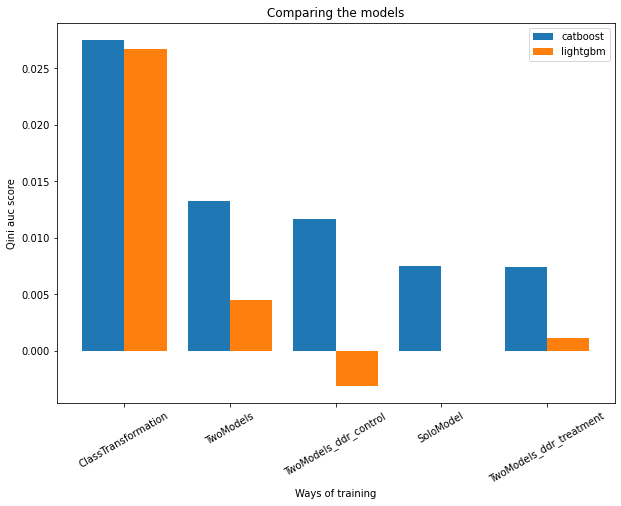

In [21]:
import matplotlib.pyplot as plt
merged_results = pd.merge(left = models_results, right = models_results_2, 
                          how="inner", on='approach')
merged_results.sort_values(
    'qini_auc_score_catboost', ascending=False,inplace=True)

plt.figure(figsize=(10, 7))
# determine the number of divisions
n_ticks = np.arange(len(merged_results['approach']))
# determine the width of the columns
w = 0.4
# determine the shift based on half the width of the columns
offset = 0.2

plt.bar(n_ticks - offset, merged_results['qini_auc_score_catboost'], 
        width=w, label='catboost')
plt.bar(n_ticks + offset, merged_results['qini_auc_score_lightgbm'],
        width=w, label = 'lightgbm')
plt.title('Comparing the models')
plt.xlabel('Ways of training')
plt.ylabel('Qini auc score')
plt.legend()
plt.xticks(n_ticks, merged_results['approach'], rotation = 30)
plt.show()

As we can see from multi-row bar charts above that CatBoostClassifier with ClassTransformation is the best approach for train on full training dataset and predict on test dataset. Let's do it # ct_full = ClassTransformation(clone(clf_))
    # ct_full = ct_full.fit(X_train, purchased_train, treatment_train)
    # uplift = ct_full.predict(X_test)
    # prediction = (uplift + 1) / 2=)

In [22]:
def save_submission(X_test:pd.DataFrame, test_pred:np.array, filename:str) -> None:
    df_result = pd.DataFrame([X_test.index.values, test_pred]).T
    df_result.rename(inplace=True, columns={0: 'client_id', 1: 'pred'})
    df_result.to_csv(os.path.join(filename), index=False)

logger.info('Training model...')
ct_full = ClassTransformation(clone(clf_))
ct_full = ct_full.fit(X_train, purchased_train, treatment_train)
logger.info('Getting predictions...')
uplift = ct_full.predict(X_test)

# since uplift = 2 ⋅ P(Z=1) − 1, so P(Z=1) is followong
test_pred = (uplift + 1) / 2

logger.info('Saving submission...')
now = datetime.now()

save_submission(
    X_test,
    test_pred,
    'submission.csv'
)
logger.info('Submission is ready')

[2023-01-11 04:06:01]	INFO	Training model...
[2023-01-11 04:06:10]	INFO	Getting predictions...
[2023-01-11 04:06:10]	INFO	Saving submission...
[2023-01-11 04:06:12]	INFO	Submission is ready


In the public leaderboard on test sample it was obtained gini = 0.04842


In [23]:
# File link below
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv

Below the top 10 features of the model

In [24]:
ct_full_feature_importances = pd.DataFrame(ct_full.estimator.feature_importances_)
ct_full_feature_importances_names = pd.DataFrame(ct_full.estimator.feature_names_)
feature_importances = pd.concat([
    ct_full_feature_importances_names,
    ct_full_feature_importances], axis=1)

feature_importances.columns = range(feature_importances.columns.size)
feature_importances.rename(inplace=True, columns={0: 'Name of feature',
                                                  1: 'Importance',})

print(feature_importances.sort_values('Importance', ascending=False).head(10))

                                       Name of feature  Importance
5                              days_from_min_to_redeem   60.586623
54     ratio_sum_express_points_spent_to_purchases_sum    1.807092
143  ratio_sum_express_points_spent_to_purchases_su...    1.268678
35                            express_points_spent_sum    0.994107
3                                                  age    0.986449
23                               product_id_count_mean    0.971451
55   ratio_sum_express_points_spent_to_sum_regular_...    0.883654
29                      regular_points_received_median    0.637969
100  ratio_days_from_last_order_eps_to_median_inter...    0.629750
83                             median_purchase_sum_eps    0.593897


<a id="4."></a> 
# 4. Summary ([Table of content link](#-1))

A model was chosen and a way of training was chosen, which gave a normal score, in my opinion.

> If you require, I'll show all my unsuccessful attempts 

> If you require, I'll show my EDA

<a id="4.1"></a> 
## 4.1 Failed attempts ([Table of content link](#-1))
1. I tried to select features based on feature_importances, but it was unsuccessful. Each time removing a feature, the result was worse than using all the features
2. Couldn't find the parameters of the models using sklearn.model_selection.RandomizedSearchCV and sklearn.model_selection.GridSearchCV with roc_auc scoring. All my attempts were unsuccessful. Therefore, I selected the parameters of the models manually.
3. I tried to train neural networks (like a perceptron) with BCELoss for this task, but it was unsuccessful (had poor results).
    
    I am sure that it is possible to create a neural network (since it is not a linear model, in bad cases NN rolls back to a linear model) for this task that will best approximate the data perfectly, but I did not have enough time to make the neural network perform well.


<a id="4.2"></a> 
## 4.2. In future versions of the program it is worth improving ([Table of content link](#-1))
1. It would be good to use Cross Validation to get a more accurate estimations of the models
2. It would be good to try SVM for this task (since this model is slow, I have not used it)
3. It would be good to well configure a neural network for this task
